# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).


In [54]:
#import warnings
#warnings.filterwarnings('ignore') # Suppress seaborn import regarding axes.color_cycle deprecation

# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as patches


from sklearn.mixture import GMM
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


sns.set_style("whitegrid")

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


## Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

---
__Explore__

We are analyzing spending (in monetary units 'm.u.') between different groups/people/businesses, so there will most likely be a fairly right-skewed distribution of data.

The most highly skewed features will dominate the variance, and most likely dominate the first PC.

Plotting our distributions of each variable with the kernal density estimations overlaid, we can see that indeed each variable is highly (positively) right-skewed.

We can also notice that some features like Fresh, Grocery, and Milk have many more higher values. When using a variance dependent technique like PCA, this should dominate the first principal components heavily and drown out other variables if the data are not scaled.

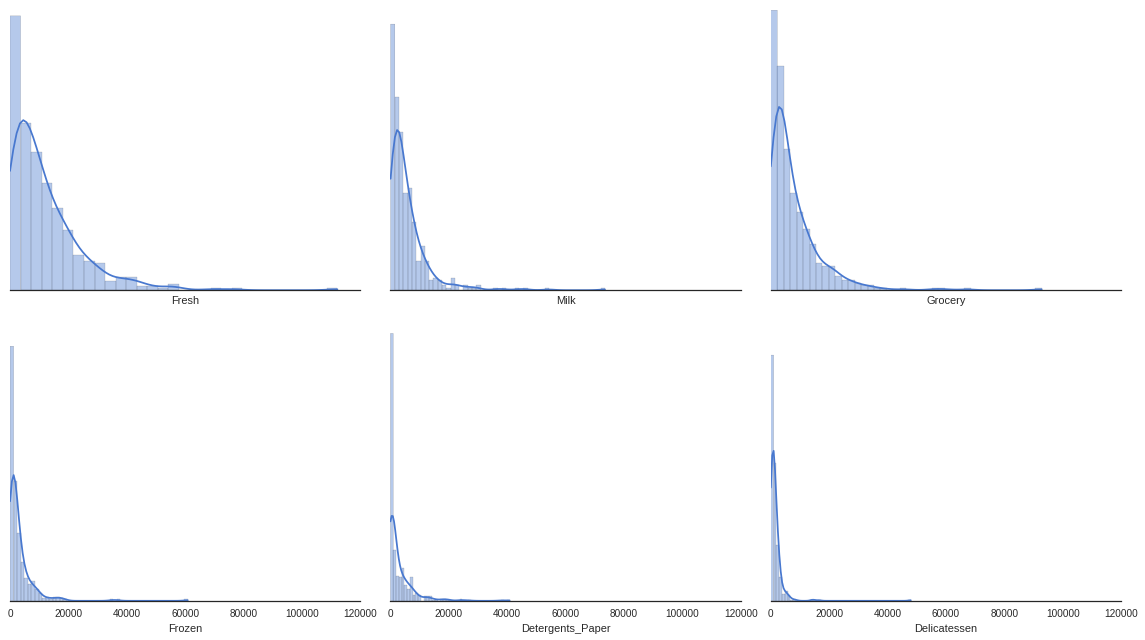

In [14]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2, 3, figsize=(16, 9), sharex=True)
sns.despine(left=True)

sns.distplot(data.Fresh, ax=axes[0, 0])
sns.distplot(data.Milk, ax=axes[0, 1])
sns.distplot(data.Grocery, ax=axes[0, 2])
sns.distplot(data.Frozen, ax=axes[1, 0])
sns.distplot(data.Detergents_Paper, ax=axes[1, 1])
sns.distplot(data.Delicatessen, ax=axes[1, 2])
plt.setp(axes, yticks=[])
plt.tight_layout()

__Answer__:

In PCA, for the first Principal Components (PC) I might expect a sort of blend of average customers/features who explain the most variance in the data with the largest highest-volume customers/categories ('Fresh') dominating.

In ICA, I might expect groups that are different/independent from each other. I might even expect one of the Independent Components (IC) put a heavy 'weight' on 'Fresh' as well.

## PCA

In [31]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
pca = PCA(n_components=data.shape[1]).fit(data)



# PCA vectors measure variance so changing the sign of the entire vectors should not have
# any influence. But this should make the results more intuitively interpretable.
# http://stats.stackexchange.com/questions/88880/does-the-sign-of-pca-or-fa-components-have-a-meaning
# pca.components_ *= -1 

# All features/variables are in the same 'monetary units' so we can choose
#  not to scale the data before PCA.
pca.fit(data)

# Print the components..
pca_names = ['PC-{}'.format(x) for x in xrange(1, 7)]

# Each row (each item from our list of pca.components) is a Principal Component 
# so we need to transpose the dataframe first, then label the columns
pc_components = pd.DataFrame(pca.components_).T

pc_components.columns = pca_names
pc_components.insert(0, 'Features', data.columns)

pc_components

,Features,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6
0,Fresh,-0.976537,-0.110614,-0.178557,-0.041876,0.015986,-0.015763
1,Milk,-0.121184,0.515802,0.509887,-0.645640,0.203236,0.033492
2,Grocery,-0.061540,0.764606,-0.275781,0.375460,-0.160292,0.410939
3,Frozen,-0.152365,-0.018723,0.714200,0.646292,0.220186,-0.013289
4,Detergents_Paper,0.007054,0.365351,-0.204410,0.149380,0.207930,-0.871284
5,Delicatessen,-0.068105,0.057079,0.283217,-0.020396,-0.917077,-0.265417


In [16]:
pca.components_[0] # Verify that the first PC matches our dataframe

array([-0.97653685, -0.12118407, -0.06154039, -0.15236462,  0.00705417,
       -0.06810471])

In [17]:
# .. and the amount of variance in the data contained in each dimension
pca_var_explained = pd.DataFrame({'Explained Variance Ratio': pca.explained_variance_ratio_})

pca_var_explained.insert(0, 'PCA', pca_names)
pca_var_explained['Explained Variance Percent'] = pca_var_explained['Explained Variance Ratio'].apply(round, args=[3]).apply(lambda x: x*100)
pca_var_explained

,PCA,Explained Variance Ratio,Explained Variance Percent
0,PC-1,0.459614,46.0
1,PC-2,0.405172,40.5
2,PC-3,0.070030,7.0
3,PC-4,0.044023,4.4
4,PC-5,0.015022,1.5
5,PC-6,0.006138,0.6


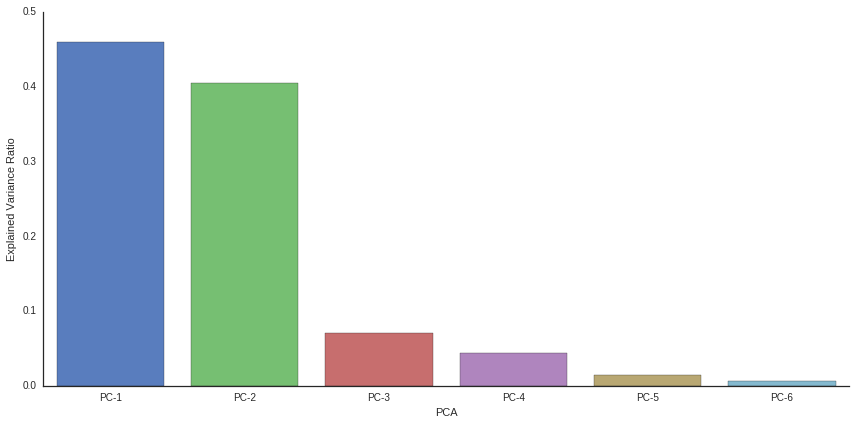

In [18]:
g = sns.factorplot(x="PCA", y="Explained Variance Ratio", data=pca_var_explained,
                   size=6, kind='bar', aspect=2)

---

**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

__Answer:__

The first PC contains about 46% of the variance of the dataset. The second contains about 40%. 

It quickly drops off from there to 7%, 4.4% 1.5%, and 0.6%. This quick dropoff, typically called an 'elbow',  is generally a good cutoff spot.

So because of this large dropoff, I would be confident in saying that 2 Principal Components, capturing about 86% of the data, would be enough to capture a large majority of the variance in the dataset.

---

In [9]:
def plot_pc(data, pc_columns, explained_var, PCA=True):
    sns.set(style="whitegrid")
    g = sns.PairGrid(data=data, size=5,
                     x_vars=pc_columns, y_vars=['Features'])
    
    g.map(sns.stripplot, size=10)

    

    # If these aren't PC components, don't include Variance explained labels
    # Set the x-bounds to be the same for both PCs
    if PCA:
        xlabels=['{}% Total Variance Explained by {}'.format(x, y) for x, y in zip(explained_var, pc_columns)]
        g.set(xlim=(-1.5, 1.5), ylabel="")
    else:
        xlabels=["" for x in explained_var]
        g.set(xlim=(-0.15, 0.15), ylabel="")
        
    for ax, xlabel, title in zip(g.axes.flat, xlabels, pc_columns):
        # Set a different title for each PC
        ax.set(title=title, xlabel=xlabel)
        
        # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

    sns.despine(left=True, bottom=True)

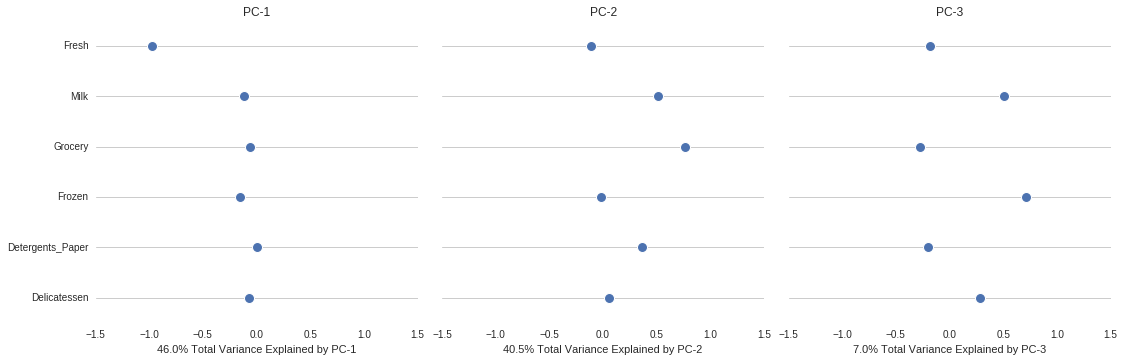

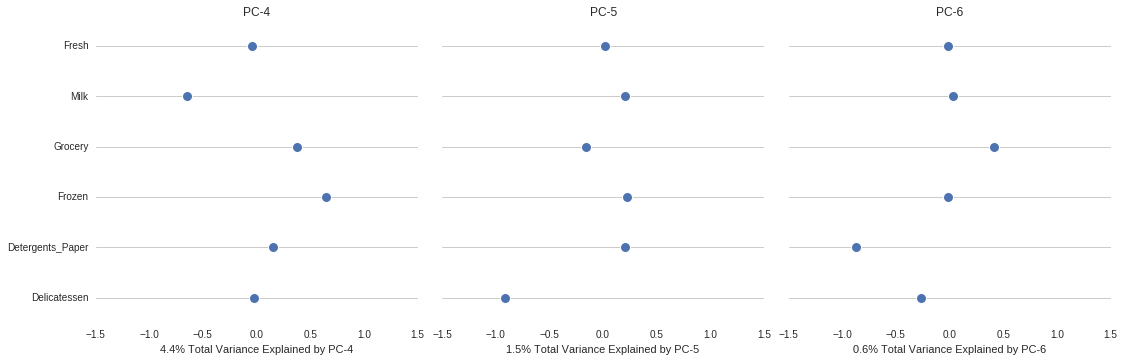

In [10]:
plot_pc(data=pc_components,
        pc_columns=pca_var_explained['PCA'][:3],
        explained_var=pca_var_explained['Explained Variance Percent'][:3])

plot_pc(data=pc_components,
        pc_columns=pca_var_explained['PCA'][3:],
        explained_var=pca_var_explained['Explained Variance Percent'][3:])

** Question 3**

What do the dimensions seem to represent? How can you use this information?

__Answer:__

Each dimension/value of each principal component represents a feature's contribution to that principal component. 

If we map the feature names back to their contributions and plot them, we can get an idea of what makes up each principal component.

The plot above shows that 'Fresh' dominates PC-1, reinforcing our intuition. Milk, Grocery, and Detergents_Paper have more influence in the make-up of PC-2.

This might show two distinct groups of customers explaining most of the variance of our customers.

One group would customers who order more Fresh products than any other product. These customers would need Fresh products, probably preferably earlier in the day, for their customers to have fresh products.

PC-2 on the other hand is made up of customers who prefer Milk, Grocery, and Detergents_Paper over other products. These customers might be more receptive to night time deliveries.

In [13]:
#U, S, V = pca._fit(data)
pca = PCA(n_components=data.shape[1]).fit(data)

pca = pca.fit(data)
#pca.components_*=-1

pc_score_vectors = pca.transform(data)

pc_score_vectors = pd.DataFrame(pc_score_vectors, columns=pc_components.columns[1:])
pc_score_vectors.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6
0,-650.022122,1585.519090,-95.390644,-4540.780481,356.637118,226.711848
1,4426.804979,4042.451509,1534.804744,-2567.655659,44.394283,468.938017
2,4841.998707,2578.762176,3801.384790,-2273.494337,-5245.385438,-2141.123329
3,-990.346437,-6279.805997,1396.959815,3310.006074,-318.152336,247.816335
4,-10657.998731,-2159.725815,-20.042982,-172.715386,-3188.717122,-510.145095


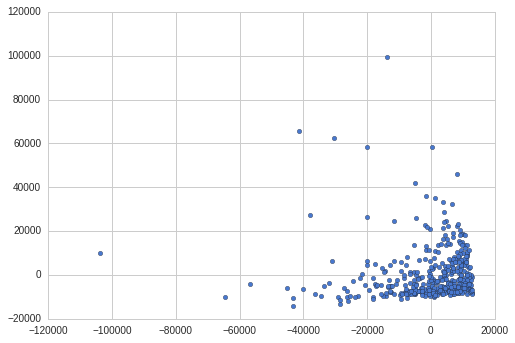

In [14]:
plt.scatter(pc_score_vectors['PC-1'], pc_score_vectors['PC-2'])

In [15]:
#pc_components.drop('Features', axis=1)
#pca.inverse_transform(pc_components.drop('Features', axis=1))
pc_components

,Features,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6
0,Fresh,-0.976537,-0.110614,-0.178557,-0.041876,0.015986,-0.015763
1,Milk,-0.121184,0.515802,0.509887,-0.645640,0.203236,0.033492
2,Grocery,-0.061540,0.764606,-0.275781,0.375460,-0.160292,0.410939
3,Frozen,-0.152365,-0.018723,0.714200,0.646292,0.220186,-0.013289
4,Detergents_Paper,0.007054,0.365351,-0.204410,0.149380,0.207930,-0.871284
5,Delicatessen,-0.068105,0.057079,0.283217,-0.020396,-0.917077,-0.265417


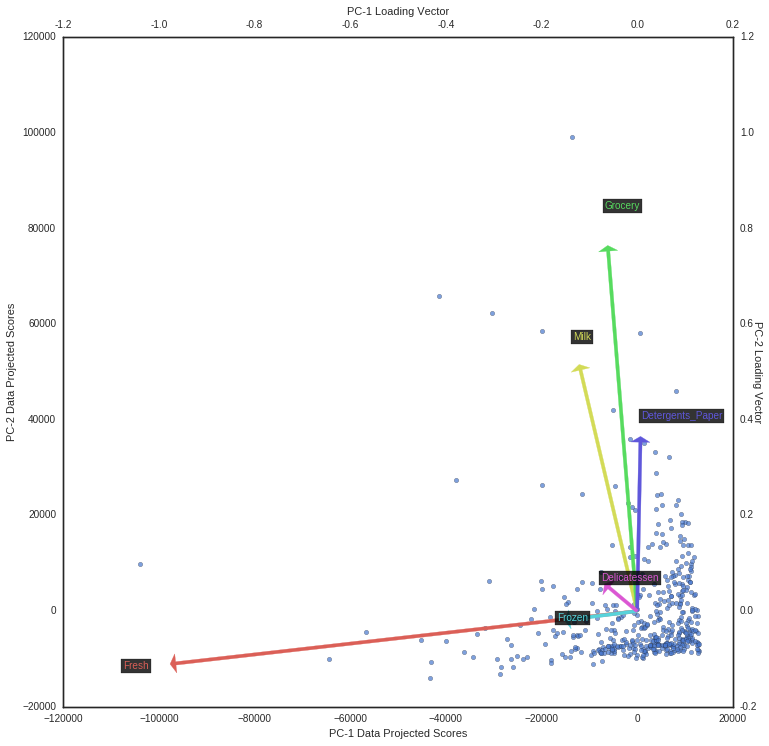

In [19]:
import matplotlib.patches as patches

sns.set_style('white')

fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(111, aspect='equal')
ax2 = ax.twiny() # Add copy for separate x-axis
ax3 = ax.twinx() # Add copy for separate y-axis

BASIC_VEC_MULT_CONSTANT = 100000.

# Add each PC basis vector from first 2 Principal Components
for pc1, pc2, rgb_color, feature in zip(pc_components['PC-1'], 
                                        pc_components['PC-2'], 
                                        sns.color_palette("hls", 6),
                                        pc_components['Features']):
    # length_includes_head=True is needed so the 'basis_vector_mult_constant'
    #  can used to derive locations for the second xy-axis as well
    p = patches.FancyArrow(0, 0, pc1*BASIC_VEC_MULT_CONSTANT, pc2*BASIC_VEC_MULT_CONSTANT,
                           width=700, fc=rgb_color, ec=rgb_color,
                           head_width=4000, head_length=1200, length_includes_head=True)

    ax.add_patch(p)
    # add 10,000 to push the labels out a bit further from the basis vector arrows
    ano = ax.annotate(feature,
                      xy=(pc1*(BASIC_VEC_MULT_CONSTANT+10000),
                          pc2*(BASIC_VEC_MULT_CONSTANT+10000)), 
                      color=rgb_color,
                      fontsize=10,
                      bbox=dict(color='black', alpha=0.8, pad=2)) # Change text bounding box attrib.

ax.scatter(pc_score_vectors['PC-1'], pc_score_vectors['PC-2'], alpha=0.7)
ax.set_xlabel('PC-1 Data Projected Scores')
ax.set_ylabel('PC-2 Data Projected Scores')

#-------- Add PC Loading Vector x/y axes BEGIN

def tick_function(x):
    V = x/BASIC_VEC_MULT_CONSTANT
    return ['%.1f' % z for z in V]

ax2.set_xlim(ax.get_xlim())
ax3.set_ylim(ax.get_ylim())

ax2.set_xticks(ax.get_xticks())
ax3.set_yticks(ax.get_yticks())

# Project the original x/y axes to the opposite side, dividing by the basis vector mult constant to
#  put it on the same scale as the PC loading vectors.
ax2.set_xticklabels(tick_function(ax.get_xticks()))
ax3.set_yticklabels(tick_function(ax.get_yticks()))

ax2.set_xlabel('PC-1 Loading Vector')
ax3.set_ylabel('PC-2 Loading Vector', rotation=270)
#-------- Add PC Loading Vector x/y axes END

sns.set_style('whitegrid')

In [20]:
pc_components

,Features,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6
0,Fresh,-0.976537,-0.110614,-0.178557,-0.041876,0.015986,-0.015763
1,Milk,-0.121184,0.515802,0.509887,-0.645640,0.203236,0.033492
2,Grocery,-0.061540,0.764606,-0.275781,0.375460,-0.160292,0.410939
3,Frozen,-0.152365,-0.018723,0.714200,0.646292,0.220186,-0.013289
4,Detergents_Paper,0.007054,0.365351,-0.204410,0.149380,0.207930,-0.871284
5,Delicatessen,-0.068105,0.057079,0.283217,-0.020396,-0.917077,-0.265417


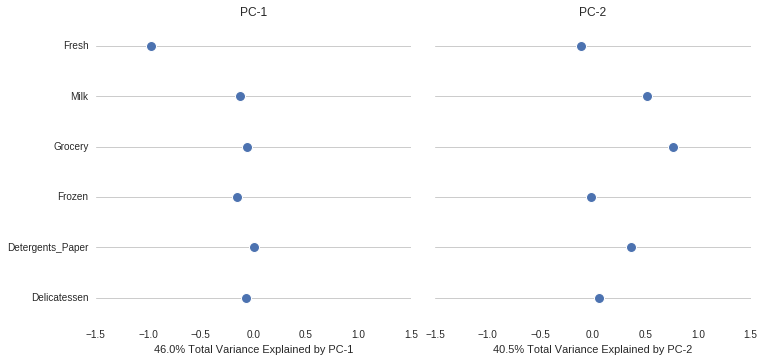

In [21]:
plot_pc(data=pc_components,
        pc_columns=pca_var_explained['PCA'][:2],
        explained_var=pca_var_explained['Explained Variance Percent'][:2])

In [22]:
pc_score_vectors.sort_values(by='PC-1').head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6
181,-103863.425320,9910.349629,2788.814929,-6749.367837,1807.542739,-437.129085
125,-64420.958954,-10008.461599,-2544.748229,6892.291359,3775.057431,375.478829
284,-56664.562569,-4286.045631,-7460.901055,3554.261829,-131.311156,2517.635058
103,-45183.311101,-6064.936093,1940.517551,9429.242740,2195.057379,384.756629
39,-43223.097334,-14003.594640,-2724.132769,2939.744680,465.712307,-1903.878422


In [23]:
data.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [24]:
data[181:182]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
181,112151,29627,18148,16745,4948,8550


In [25]:
data[125:126]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
125,76237,3473,7102,16538,778,918


In PCA, magnitude is king. ~~Negative and positive values only matter in the relative relationship between one variable to the others.~~

Here, we can see that the first PC, which explains 46% of total variance, Fresh products dominate with a very large magnitude.

The second PC has higher positive contributions from Milk and Grocery than other features.

---

### ICA

In [30]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

ica = FastICA(n_components=6,random_state=1337)

S_ = ica.fit_transform(data_scaled)
A_ = ica.mixing_

#ic_inv_scaled = scaler.inverse_transform(ica.components_)

ic_names = ['IC-{}'.format(x) for x in xrange(1, 7)]

# Print the independent components; transpose into IC columns
ica_components =  pd.DataFrame(ica.components_).T
ica_components.columns = ic_names

ica_components.insert(0, 'Features', data.columns)
ica_components

,Features,IC-1,IC-2,IC-3,IC-4,IC-5,IC-6
0,Fresh,0.003334,0.004429,-0.004986,0.001681,-0.010866,-0.050148
1,Milk,-0.008653,0.036004,-0.001965,-0.066168,-0.001788,0.006143
2,Grocery,-0.124390,0.009121,-0.006488,0.065250,0.008139,0.008137
3,Frozen,0.006757,0.000415,-0.002582,0.002918,0.054070,0.003375
4,Detergents_Paper,0.134901,0.009178,0.002268,0.003750,-0.002757,-0.010452
5,Delicatessen,0.014754,-0.012884,0.051198,0.012948,-0.016611,0.002694


In [33]:
# Confirm that our column for IC-1 matches the first item entry from ica.components_
ica.components_[0]

array([ 0.00333431, -0.00865308, -0.12438993,  0.00675685,  0.13490074,
        0.01475364])

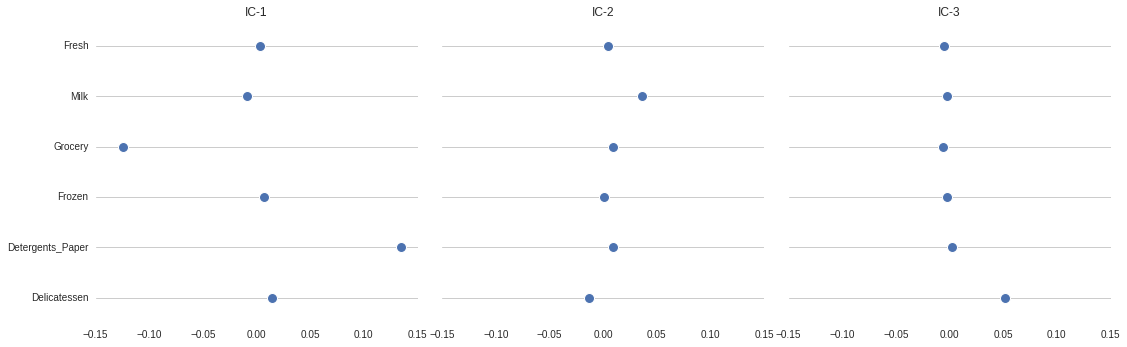

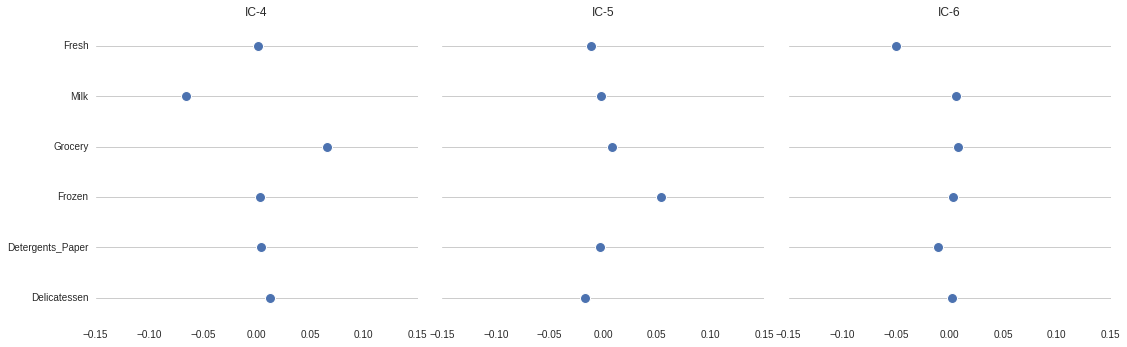

In [39]:
plot_pc(data=ica_components, pc_columns=['IC-1', 'IC-2', 'IC-3'], explained_var=['', '', ''], PCA=False)
plot_pc(data=ica_components, pc_columns=['IC-4', 'IC-5', 'IC-6'], explained_var=['', '', ''], PCA=False)

**Question 4:**

For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

__Answer:__

The labeling/ordering and/or sign of the Independent Components (IC's) might change after re-running ICA, but the same six IC's are represented always reperesented.

This is because FastICA is an iterative algorithm with randomized initial weights, but the FastICA components are independent so ordering/sign shouldn't matter anyway.

In order to describe a specific order of IC's and give their interpetations, we've set a random seed.

# TODO: REWRITE

1. __An IC with higher than average Fresh orders.__ This points to stores which might prefer orders early in the day such as __??????__, since getting fresh products at night would lead to less than fresh products for the morning.

2. __An IC with higher than average Grocery orders.__
3. __An IC with lower than average Frozen products.__
4. __An IC with much higher Grocery orders, and much lower Detergents_Paper orders.__
5. __An IC with higher Delicatessen orders.__
6. __An IC with lower milk orders, but higher Grocery and Delicatessen.__

## Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**Question 5:**

What are the advantages of using K Means clustering or Gaussian Mixture Models?

__Answer__:

Kmeans ['Equal Variance Assumption'](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#example-cluster-plot-kmeans-assumptions-py)

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [51]:
def plot_clusters(clf, reduced_PCA_data, princ_comps, pc_scores, model):
    
    # Obtain labels for each point in mesh. Use last trained model.
    reduced_PCA_data = np.array(reduced_PCA_data)
    
    # Plot the decision boundary by building a mesh grid to populate a graph.
    x_min, x_max = reduced_PCA_data[:, 0].min() - 1, reduced_PCA_data[:, 0].max() + 1
    y_min, y_max = reduced_PCA_data[:, 1].min() - 1, reduced_PCA_data[:, 1].max() + 1
    hx = (x_max-x_min)/1000.
    hy = (y_max-y_min)/1000.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))
    
    if model == 'KMeans':
        centroids = clf.cluster_centers_
    elif model == 'GMM':
        centroids = clf.covars_
    else:
        raise Exception("Unsupported Model: Use 'KMeans' or 'GMM'")
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    fig = plt.figure(1, figsize=(16, 9))
    
    #-------------------- Superimpose top 2 PC vectors BEGIN
    ax = fig.add_subplot(111, aspect='equal')
    
    BASIC_VEC_MULT_CONSTANT = 80000.
    # Add each PC basis vector from first 2 Principal Components
    for pc1, pc2, rgb_color, feature in zip(princ_comps['PC-1'], 
                                            princ_comps['PC-2'], 
                                            sns.color_palette("hls", 6),
                                            princ_comps['Features']):
        # length_includes_head=True is needed so the 'basis_vector_mult_constant'
        #  can used to derive locations for the second xy-axis as well
        p = patches.FancyArrow(0, 0, pc1*BASIC_VEC_MULT_CONSTANT, pc2*BASIC_VEC_MULT_CONSTANT,
                               width=700, fc=rgb_color, ec=rgb_color,
                               head_width=4000, head_length=1200, length_includes_head=True)

        ax.add_patch(p)
        # add 10,000 to push the labels out a bit further from the basis vector arrows
        ano = ax.annotate(feature,
                          xy=(pc1*(BASIC_VEC_MULT_CONSTANT+10000.),
                              pc2*(BASIC_VEC_MULT_CONSTANT+10000.)), 
                          color=rgb_color,
                          fontsize=10,
                          bbox=dict(color='black', alpha=0.8, pad=2)) # Change text bounding box attrib.

    ax.scatter(pc_scores['PC-1'], pc_scores['PC-2'], alpha=0.7)
    ax.set_xlabel('PC-1 Data Projected Scores')
    ax.set_ylabel('PC-2 Data Projected Scores')
    #-------------------- Superimpose top 2 PC vectors END

    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_PCA_data[:, 0], reduced_PCA_data[:, 1], 'k.', markersize=2)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())

    plt.show()

In [52]:
# TODO: First we transform the data using PCA to capture variation
pc_score_vectors = pca.transform(data)
pc_score_vectors = pd.DataFrame(pc_score_vectors, columns=pc_components.columns[1:])

# Then we reduce the data to two dimensions by selecting only the first two PCs
reduced_data = pc_score_vectors[['PC-1', 'PC-2']] # Pull out onlt 
reduced_data[:10]  # print up to 10 elements


,PC-1,PC-2
0,-650.022122,1585.519090
1,4426.804979,4042.451509
2,4841.998707,2578.762176
3,-990.346437,-6279.805997
4,-10657.998731,-2159.725815
5,2765.961593,-959.870727
6,715.550892,-2013.002266
7,4474.583667,1429.496972
8,6712.095397,-2205.909156
9,4823.634354,13480.559205


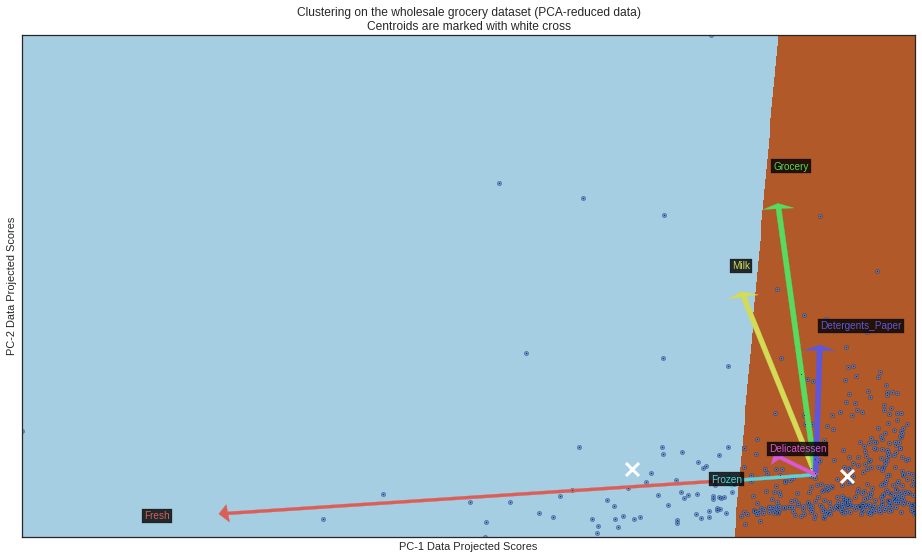

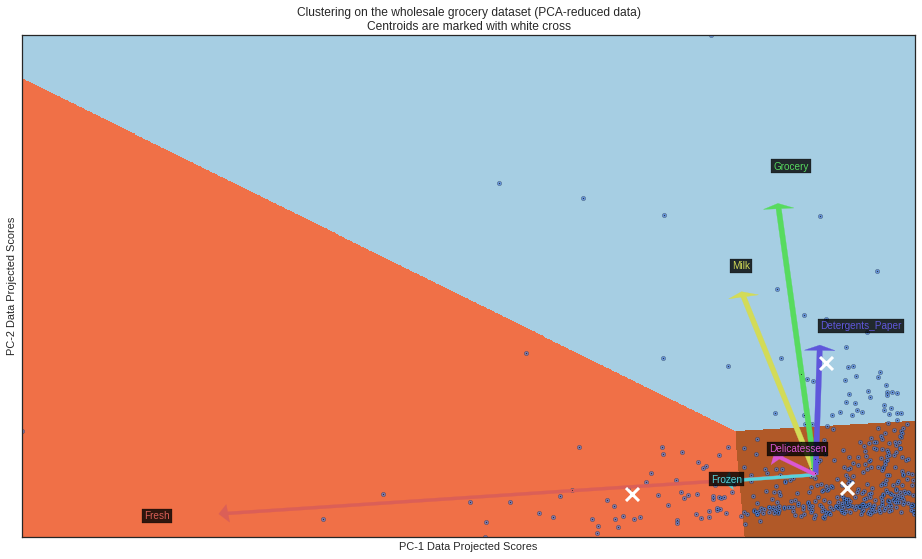

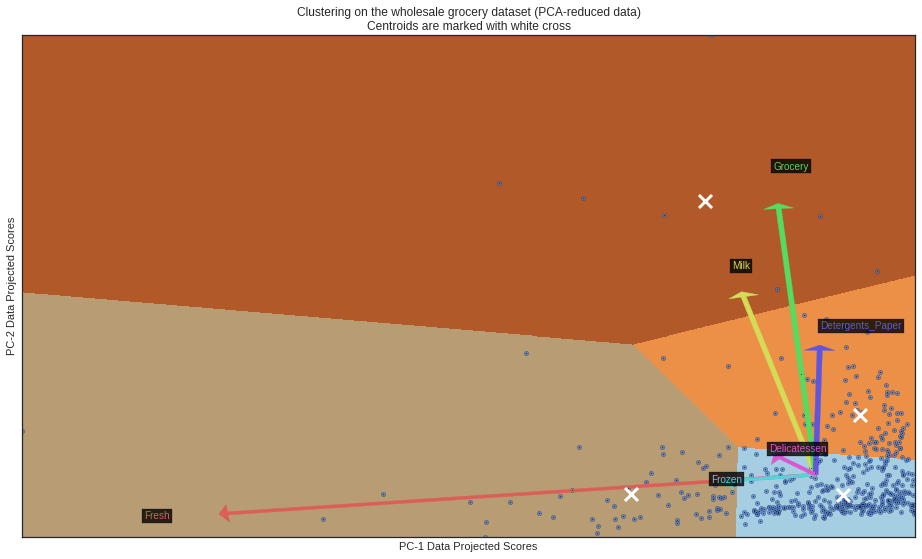

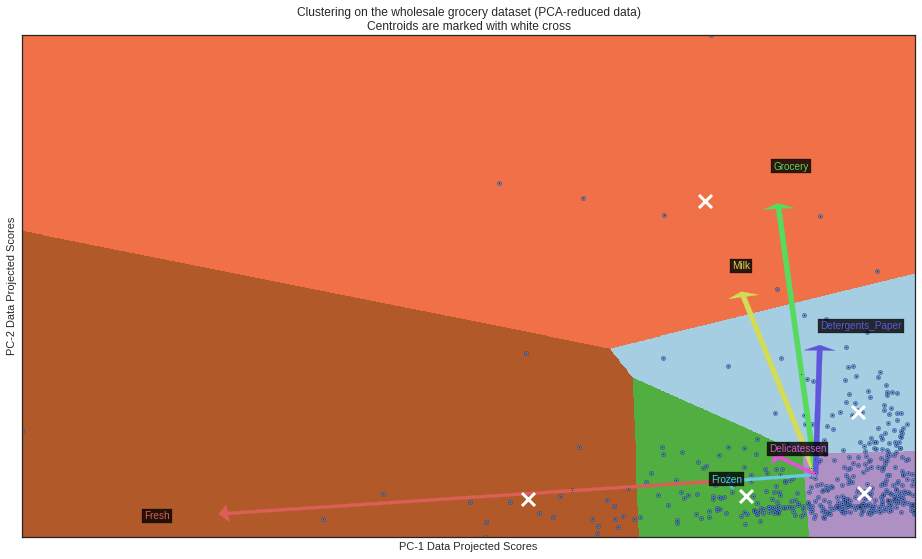

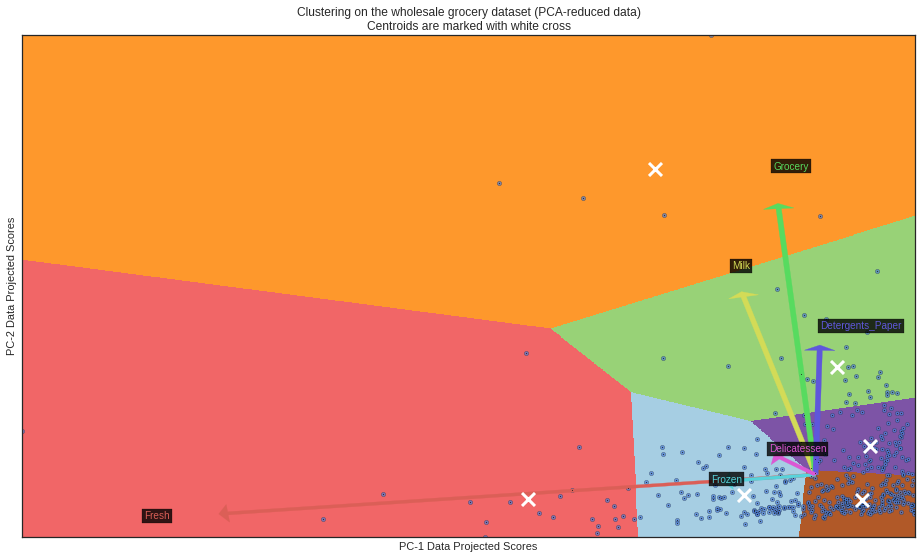

In [53]:
clusters = KMeans(n_clusters=2).fit(reduced_data)
plot_clusters(clusters, reduced_data, pc_components, pc_score_vectors, model='KMeans')

clusters = KMeans(n_clusters=3).fit(reduced_data)
plot_clusters(clusters, reduced_data, pc_components, pc_score_vectors, model='KMeans')

clusters = KMeans(n_clusters=4).fit(reduced_data)
plot_clusters(clusters, reduced_data, pc_components, pc_score_vectors, model='KMeans')

clusters = KMeans(n_clusters=5).fit(reduced_data)
plot_clusters(clusters, reduced_data, pc_components, pc_score_vectors, model='KMeans')

clusters = KMeans(n_clusters=6).fit(reduced_data)
plot_clusters(clusters, reduced_data, pc_components, pc_score_vectors, model='KMeans')

In [94]:
all_gmm = []
for i in np.arange(1, 13):
    gmm = GMM(n_components=i).fit(reduced_data)
    all_gmm.append([i, gmm.bic(reduced_data), gmm])

gmm_models = pd.DataFrame(all_gmm, columns=['n_components', 'BIC', 'model'])

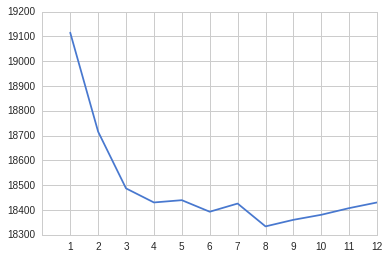

In [101]:
plt.plot(gmm_models["n_components"], gmm_models["BIC"], '-')
plt.xticks(xrange(1, 13))
plt.show()

In [108]:
# Much greater than 10; best model at 8 n_components
gmm_models[gmm_models['n_components'] == 7]['BIC'].values - \
gmm_models[gmm_models['n_components'] == 8]['BIC'].values

array([ 92.16118993])

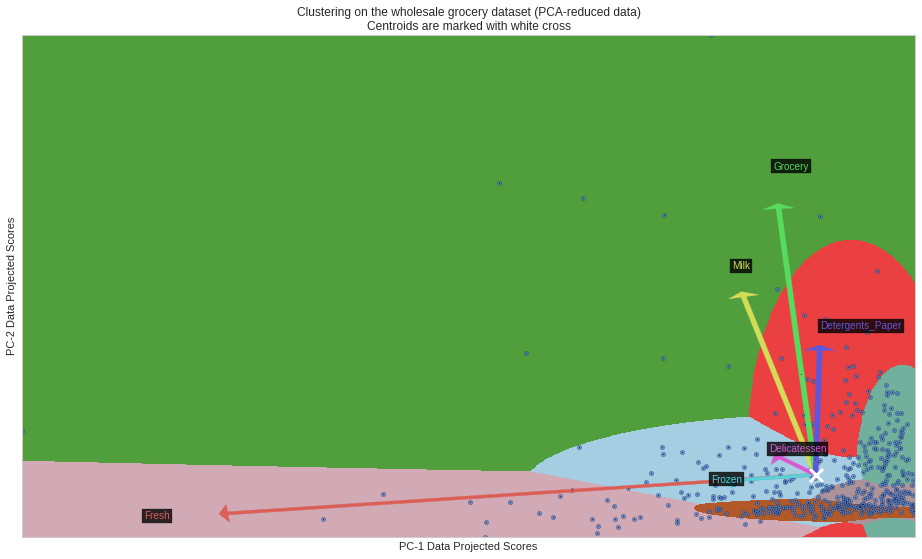

In [119]:
temp_gmm = gmm_models[gmm_models['n_components'] == 8]['model'].values[0]
plot_clusters(temp_gmm, reduced_data, pc_components, pc_score_vectors, model='GMM')

18715.9033785


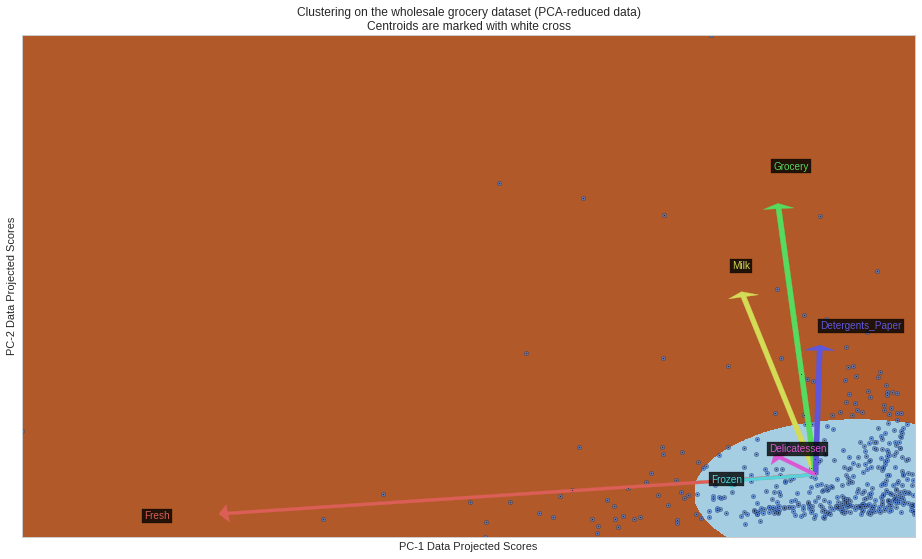

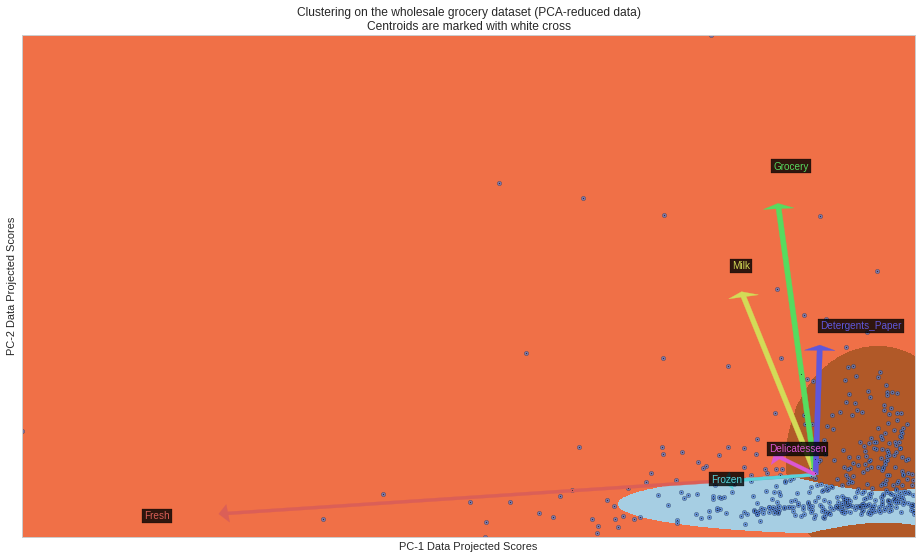

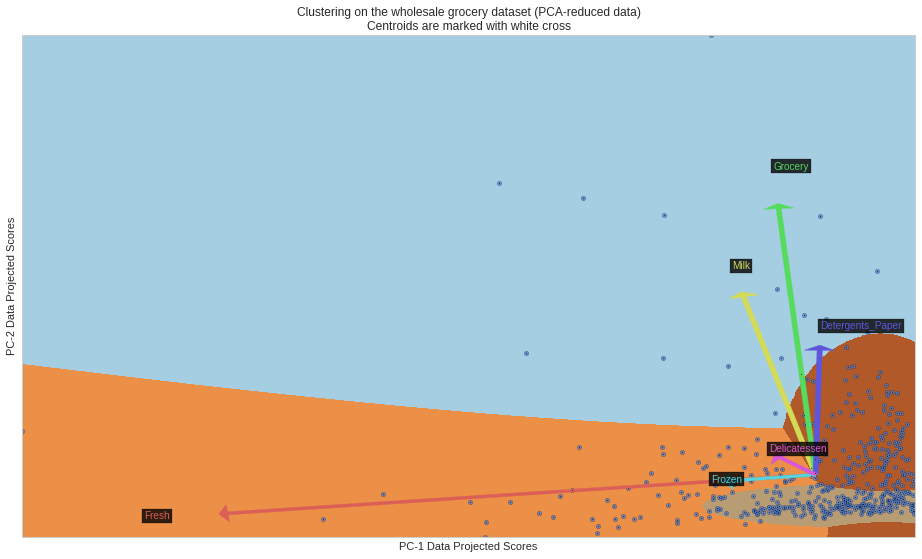

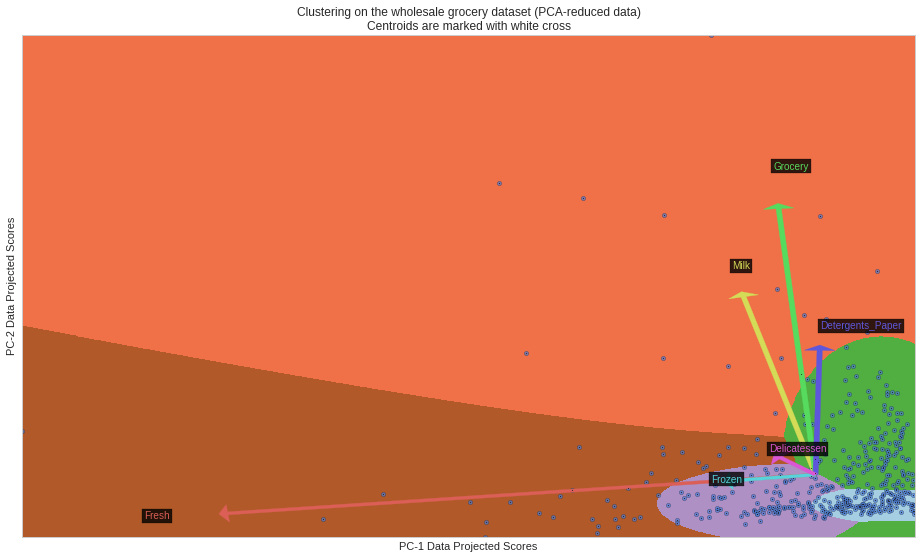

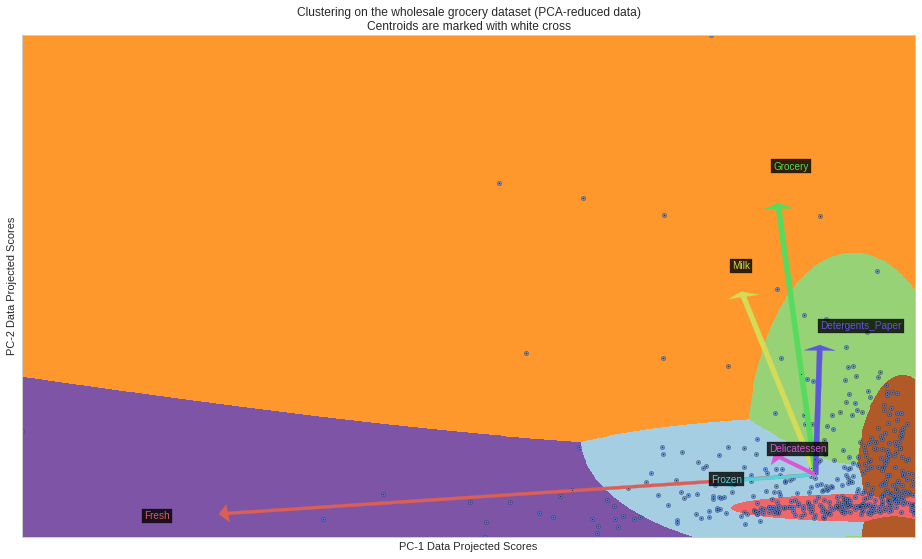

In [65]:
mixtures = GMM(n_components=2).fit(reduced_data)
plot_clusters(mixtures, reduced_data, pc_components, pc_score_vectors, model='GMM')

mixtures = GMM(n_components=3).fit(reduced_data)
plot_clusters(mixtures, reduced_data, pc_components, pc_score_vectors, model='GMM')

mixtures = GMM(n_components=4).fit(reduced_data)
plot_clusters(mixtures, reduced_data, pc_components, pc_score_vectors, model='GMM')

mixtures = GMM(n_components=5).fit(reduced_data)
plot_clusters(mixtures, reduced_data, pc_components, pc_score_vectors, model='GMM')

mixtures = GMM(n_components=6).fit(reduced_data)
plot_clusters(mixtures, reduced_data, pc_components, pc_score_vectors, model='GMM')

18333.8761655


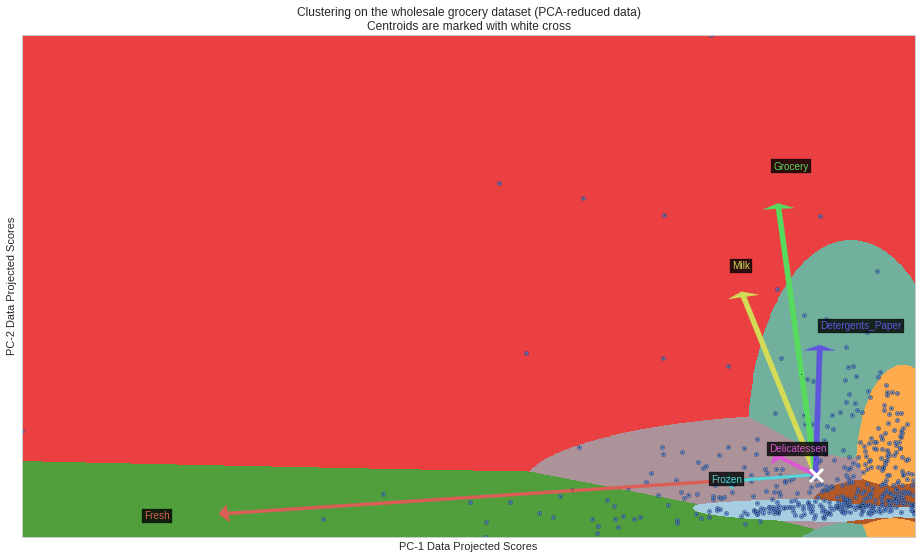

In [75]:
mixtures = GMM(n_components=8).fit(reduced_data)
print mixtures.bic(reduced_data)
plot_clusters(mixtures, reduced_data, pc_components, pc_score_vectors, model='GMM')

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: [Bayesian Information Criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion) ... > 10 

>Both BIC and AIC resolve this problem by introducing a penalty term for the number of parameters in the model; the penalty term is larger in BIC than in AIC.

>The BIC generally penalizes free parameters more strongly than the Akaike information criterion, though it depends on the size of n and relative magnitude of n and k.

>The BIC criterion suffers from two main limitations

>1. the above approximation is only valid for sample size n much larger than the number k of parameters in the model.

>2. the BIC cannot handle complex collections of models as in the variable selection (or feature selection) problem in high-dimension.

### Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: [Hastie et al](ISLR 6th Printing)

GMM might be better in this case because there seem to be a small of clusters of similar customers, while a small subset of customers are quite different from each other and all other customers. These may be those outliers that order a very high volume of some combination of Del, Milk, etc. 

K-means would fit those customers in one cluster, possibly distorting the other better formed clusters to accommodate these outliers that don't really belong to any specific cluster.

Mixture models, like GMM, are better able to handle these outliers.

__handling perturbations in data__

**Question 9:**

How would you use that technique to help the company design new experiments?

__Answer:__

I might use GMM to identify and target specific clusters/types of customers with specific delivery times. 

We have a cluster of small businesses dealing in mostly 'Fresh' products who would want regular morning deliveries.

Other smaller to mid-size groups ordering very little fresh in comparison to other types of prodcuts might want regular or semi-regular night deliveries.

The larger clusters/types might prefer bulk deliveries. Though they might prefer more regular/earlier deliveries as well if they specialize in Fresh products.

**Question 10:**

How would you use that data to help you predict future customer needs?

__Answer:__

I would predict current future customer needs by the cluster they were in, and how close to the center of cluster they are in. I might also contact those near the borders for their preferences as they are closer to belonging to two different gaussians/clusters.

For future customers, it's simply a matter of projecting their first orders (or predicted orders) into this space using the PC components and GMM means to see where they might best fit into our shipping plans.

And of course, continually updating our models as we get more data. This is especially true once we start to get data on who are happy with whichever shipping plans they end up on, because then it becomes a supervised learning problem.